In [1]:
%run '../definitions.ipynb'

In [17]:
def simulate_photon_times(n_photons, t1, t3, fs, tts):
    times = np.zeros(n_photons)
    n_singlets = np.random.binomial(n=n_photons, p=fs)
    times += np.concatenate([
        np.random.exponential(t1, n_singlets),
        np.random.exponential(t3, n_photons - n_singlets)
    ])
    np.random.shuffle(times)
    times += np.random.normal(0, tts, size=n_photons)
    return times
    

In [57]:
def build_likelihood_function(n_photons, t1, t3, fs, tts, hist_range, hist_bins, 
                              offset = 1e-6, plot=False, ):
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    vals, edges  = np.histogram(times, range = hist_range, bins = hist_bins, normed=True)
    vals = np.max([vals, np.ones(len(vals)) * offset], axis=0)
    centers = 0.5 * (edges[:-1] + edges[1:])
    def f(x):
        return np.interp(x, centers, vals)
    def negloglikelihood(x):
        return np.interp(x, centers, -np.log(vals))
    
    if plot:
        x_plot = centers
        plt.hist(times, range = hist_range, bins = hist_bins, normed=True, histtype = 'step')
        plt.plot(centers, f(centers))
        plt.yscale('log')
    return negloglikelihood

In [ ]:
def simulate_s1_times(n_photons, t1, t3, fs, tts, photons_per_s1):
    times = simulate_photon_times(n_photons, t1, t3, fs, tts)
    n_s1s = int(np.floor(n_photons / photons_per_s1))
    times = times[:(n_s1s * photons_per_s1)]
    s1_times = np.split(times, n_s1s)
    return np.array(s1_times)

In [ ]:
from tqdm import tqdm
def max_likelihood(s1_times, f):
    shifts = []
    likes = []
    for s1 in tqdm(s1_times):
        optres = scipy.optimize.minimize(lambda x: np.sum(f(s1 + x)), 0.)
        shifts.append(optres.x[0])
        likes.append(optres.fun)
    return likes, shifts

## Build likelihoods

In [111]:
f_er = build_likelihood_function(int(1e7), 1.5, 24.5, 0.18, 1.75, hist_range = (-50, 250), hist_bins = 1000)
f_nr = build_likelihood_function(int(1e7), 1.5, 21.5, 0.23, 1.75, hist_range = (-50, 250), hist_bins = 1000)


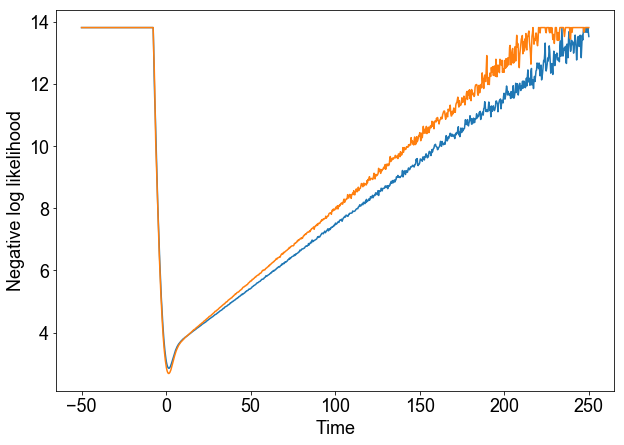

In [113]:
t = np.linspace(-50, 250, 1000)
plt.plot(t, f_er(t))
plt.plot(t, f_nr(t))
plt.xlabel('Time')
plt.ylabel('Negative log likelihood')

## Build ER and NR s1 samples

In [144]:
s1_size = 1000 # photons
n_ph = int(1e5)

In [145]:
s1s_er = simulate_s1_times(n_ph, 1.5, 24.5, 0.18, 1.75, s1_size)
s1s_nr = simulate_s1_times(n_ph, 1.5, 21.5, 0.23, 1.75, s1_size)

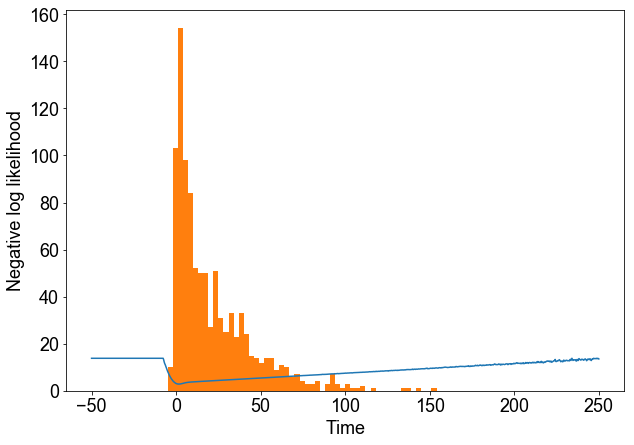

In [146]:
t = np.linspace(-50, 250, 1000)
plt.plot(t, f_er(t))
plt.xlabel('Time')
plt.ylabel('Negative log likelihood')
plt.hist(s1s_er[0], bins=100, range=(-50, 250))
plt.show()

In [147]:
s1s_er_erlikelihood = max_likelihood(s1s_er, f_er)
s1s_er_nrlikelihood = max_likelihood(s1s_er, f_nr)
s1s_nr_erlikelihood = max_likelihood(s1s_nr, f_er)
s1s_nr_nrlikelihood = max_likelihood(s1s_nr, f_nr)

100%|██████████| 100/100 [00:03<00:00, 29.16it/s]


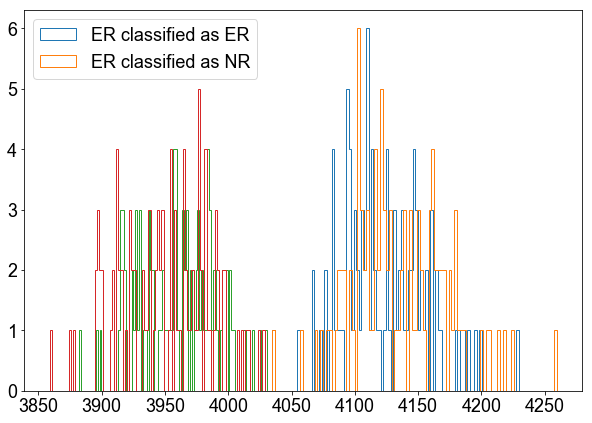

In [150]:
plt.hist(s1s_er_erlikelihood[0], bins=100, histtype='step', label='ER classified as ER')
plt.hist(s1s_er_nrlikelihood[0], bins=100, histtype='step', label='ER classified as NR')
plt.hist(s1s_nr_erlikelihood[0], bins=100, histtype='step')
plt.hist(s1s_nr_nrlikelihood[0], bins=100, histtype='step')
plt.legend()
plt.show()

What? What? Am I smearing twice?

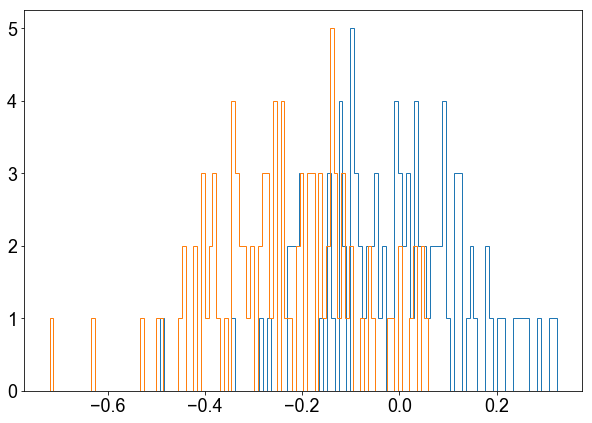

In [151]:
plt.hist(s1s_er_erlikelihood[1], bins=100, histtype='step')
plt.hist(s1s_er_nrlikelihood[1], bins=100, histtype='step')
plt.show()

In [108]:
likes, shifts = max_likelihood(s1_times, f)

100%|██████████| 500/500 [00:08<00:00, 57.05it/s]


(array([   3.,   22.,   61.,   89.,  127.,   84.,   68.,   30.,   14.,    2.]),
 array([ 68.3817801 ,  71.06925792,  73.75673575,  76.44421358,
         79.13169141,  81.81916924,  84.50664707,  87.19412489,
         89.88160272,  92.56908055,  95.25655838]),
 <a list of 10 Patch objects>)

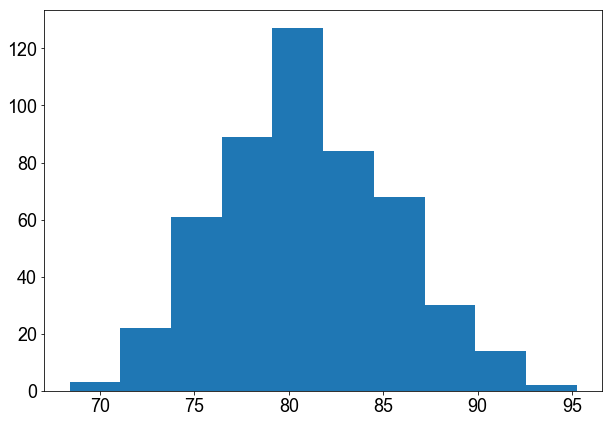

In [110]:
plt.hist(likes)

In [49]:
np.max([[1,2,3], np.ones(3) * 2], axis=0)

array([ 2.,  2.,  3.])